# Pylops - CUDA solvers

### Author: M.Ravasi

In this notebook we test Pytorch powered operators with conjugate-gradient solvers

In [1]:
#!pip install pylops
#!pip install git+https://git@github.com/equinor/pylops.git@master
#!pip install git+https://git@github.com/equinor/pylops-gpu.git@master

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from scipy.signal import triang
from pylops import Diagonal, MatrixMult, FirstDerivative
from pylops.utils import dottest
from pylops.signalprocessing import Convolve1D

from scipy.sparse.linalg import cg, lsqr
from pylops_gpu.utils.backend import device
from pylops_gpu.utils import dottest as gdottest
from pylops_gpu import Diagonal as gDiagonal
from pylops_gpu import Identity as gIdentity
from pylops_gpu import MatrixMult as gMatrixMult
from pylops_gpu import FirstDerivative as gFirstDerivative
from pylops_gpu.signalprocessing import Convolve1D as gConvolve1D
from pylops_gpu.optimization.cg import cg as gcg
from pylops_gpu.optimization.cg import cgls as gcgls

Populating the interactive namespace from numpy and matplotlib


In [3]:
dev = device()
print('PyLops-gpu working on %s...' % dev)

torch.cuda.empty_cache()

PyLops-gpu working on cpu...


### CG for square systems

In [4]:
n = 10
x = np.ones(n, dtype=np.float32)

A = np.random.randn(n, n).astype(np.float32)
A = np.dot(A.T, A)
print('eigs', np.linalg.eig(A)[0])

Aop = MatrixMult(A)
gAop = gMatrixMult(torch.from_numpy(A))

y = Aop.matvec(x)
gy = gAop.matvec(torch.from_numpy(x))

xinv_sp = cg(Aop, y, maxiter=2*n)[0]
xinv = gcg(gAop, gy, torch.zeros(n, dtype=torch.float32), 2*n)
print(xinv_sp)
print(xinv)

eigs [25.975649   16.48591    13.685203    8.482123    6.362227    3.2930698
  0.03359816  0.22574688  1.3597002   2.2951856 ]
[1.0000018  0.99999802 0.99999837 1.00000078 1.00000049 0.99999932
 1.00000027 0.99999855 1.0000014  1.00000019]
(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000]), 16)


In [5]:
xinv = gAop / gy
print(xinv)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])


In [6]:
gAop.explicit=False
xinv = gAop / gy
print(xinv)

tensor([0.4943, 1.4472, 0.9536, 0.5194, 0.5970, 1.1453, 0.7058, 0.9926, 0.9538,
        1.0156])


### CGLS for rectangular systems

[0.99999996 1.99999985 2.99999987 3.99999987 4.99999987]
tensor([1.0000, 2.0000, 3.0000, 4.0000, 5.0000])
tensor([1.0000, 2.0000, 3.0000, 4.0000, 5.0000])


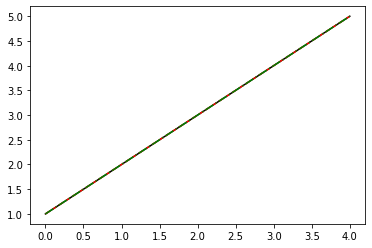

In [7]:
n, m = 100, 5
x = np.arange(m, dtype=np.float32) + 1

A = np.random.randn(n, m).astype(np.float32)

Aop = MatrixMult(A)
gAop = gMatrixMult(torch.from_numpy(A).to(dev), device=dev)

y = Aop.matvec(x)
gy = gAop.matvec(torch.from_numpy(x).to(dev))

xinv_sp = lsqr(Aop, y, iter_lim=2*n)[0]
xinv = gcgls(gAop, gy, torch.zeros(m, dtype=torch.float32), niter=2*n)[0]
xinv1 = gcgls(gAop, gy, torch.ones(m, dtype=torch.float32), damp=1e-4, niter=2*n)[0]
print(xinv_sp)
print(xinv)
print(xinv1)

plt.figure()
plt.plot(xinv_sp, 'k')
plt.plot(xinv.cpu().numpy(), '--r');
plt.plot(xinv1.cpu().numpy(), '-.g');

And using the `\` operator

In [8]:
xinv = gAop / gy
print(xinv)

tensor([[1.0000],
        [2.0000],
        [3.0000],
        [4.0000],
        [5.0000]])


In [9]:
gAop.explicit=False
xinv = gAop / gy
print(xinv)

tensor([1.0000, 2.0000, 3.0000, 4.0000, 5.0000])
